# Extract spectra based on source plane regions

In [79]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
from astropy.modeling import models, fitting
from reproject import reproject_exact,reproject_interp
from astropy.wcs import WCS
from astropy.convolution import Gaussian2DKernel, convolve
import glob
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as uu

z = 1.033

In [ ]:
PSF stuff

# 0) Morphology

This object is quity messy because the arc is not a complete image of the galaxy. So we have to use the full image (in the counter image) to get a sense of the morphology

<IPython.core.display.Javascript object>


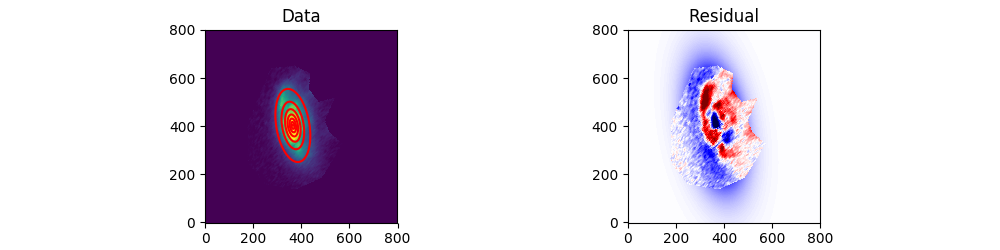

 amplitude	0.03	0.00
     r_eff	130.19	1.83
         n	1.00	0.40
       x_0	364.57	0.83
       y_0	402.26	0.01
     ellip	0.55	0.01
effective radius 5.75 +/- 0.08 kpc
('center', [array(181.55001580768533), array(-8.8007578760292)])
inclination (F160W): 63.38 deg


In [60]:
# Data
im = fits.getdata('../../Data/Lensing/MACS1206/SourcePlane_MACS1206_ci_F160w.fits')
h  = fits.getheader('../../Data/Lensing/MACS1206/SourcePlane_MACS1206_ci_F160w.fits')
kpc_per_pix = h['CDELT2'] * cosmo.kpc_proper_per_arcmin(z).to('kpc/deg')
wcs = WCS('../../Data/Lensing/MACS1206/SourcePlane_MACS1206_ci_F160w.fits')

# Model
p_init = models.Sersic2D(amplitude=0.01,r_eff=100,n=1.,x_0=362,y_0=388,ellip=0.6,theta=np.pi/4, fixed={'n':True})#,bounds={'ellip':[0.5,1]})
fit_p = fitting.LevMarLSQFitter()

# Fit
y, x = np.mgrid[:im.shape[0], :im.shape[1]]
p = fit_p(p_init, x, y, im)

# Plot the data with the best-fit model
fig, ax = plt.subplots(1,2,figsize=(10, 2.5))
ax[0].imshow(im, origin='lower',  vmin=0, vmax=0.1)
ax[0].set_title("Data")
ax[0].contour(p(x, y), origin='lower',colors='r')
ax[1].imshow(im - p(x, y), origin='lower',cmap='seismic', vmin=-0.02,vmax=0.02)
ax[1].set_title("Residual")

# Calculate and print errors
err=  [np.sqrt(fit_p.fit_info['param_cov'][i][i]) for i in range(6) ]
for i,x,e in zip(p.param_names,p.parameters,err):
    print('%10s\t%0.2f\t%0.2f'%(i,x,e))

# Convert to physical units
r_eff =     p.r_eff.value* h['CDELT2']*cosmo.kpc_proper_per_arcmin(0.725).to('kpc/deg')
r_eff_err = err[1]* h['CDELT2']*cosmo.kpc_proper_per_arcmin(0.725).to('kpc/deg')
print('effective radius %0.2f +/- %0.2f kpc'%(r_eff.value,r_eff_err.value))
print('center', wcs.all_pix2world(p.x_0.value,p.y_0.value, 0))
print('inclination (F160W): %0.2f deg'%np.rad2deg(np.arccos(1-p.ellip.value)))

### 1.1) Distance map

In [61]:
def projected_distance(im,cx,cy,e,t,scale=1):
    i = np.arccos(1-e)
    x,y = np.meshgrid(range(im.shape[0]),range(im.shape[1]))
    x_rot = (x-cx)*np.cos(t)+(y-cy)*np.sin(t)
    y_rot = (y-cy)*np.cos(t)-(x-cx)*np.sin(t)
    return np.sqrt((x_rot)**2+((y_rot)/np.cos(i))**2)*scale

<IPython.core.display.Javascript object>


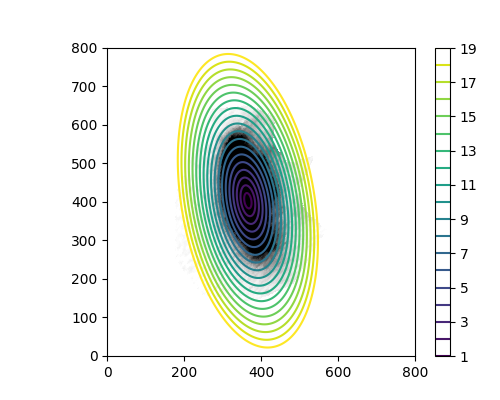

In [62]:
# Distance map
dist_map = projected_distance(im,p.x_0,p.y_0,p.ellip,p.theta,kpc_per_pix.value)

fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.imshow(im,origin='lower',cmap='Greys',vmin=0,vmax=0.03)
cax = ax.contour(dist_map,origin='lower',levels=range(20))
plt.colorbar(cax,fraction=0.04)

# Save maps
fits.writeto('macs1206_distance_kpc_source_plane.fits',data=dist_map,header=h,overwrite=True)

### 2 ) Put radii and distance in image plane using lenstool 

    But now we look at the arc, not the counter image we used to produce this image. Notice how the centre is NOT in the image.

<IPython.core.display.Javascript object>


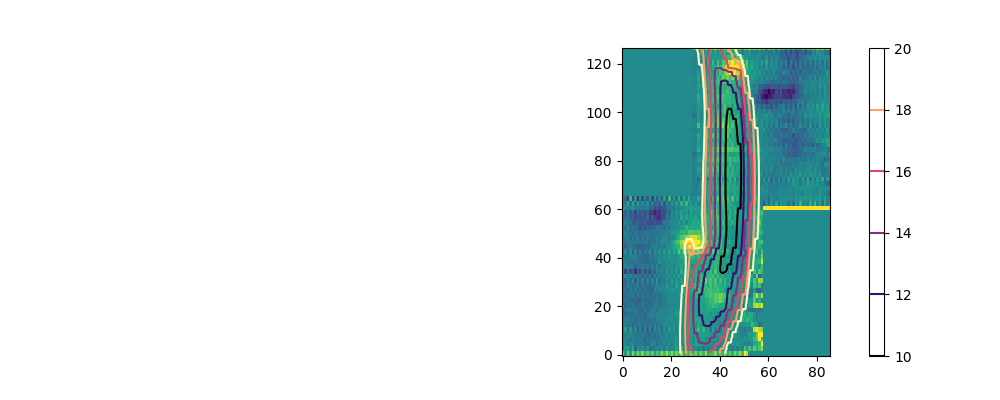

In [70]:
ip_im = fits.getdata('../../Data/Images/MACS1206/MACS1206_aligned_wcs.fits')
ip_header = fits.getheader('../../Data/Images/MACS1206/MACS1206_aligned_wcs.fits')
ip_dist_map,_ = reproject_interp('simul_macs1206_distance.fits',ip_header,order=0)
ip_dist_map[ip_dist_map<=0] = np.nan

fig, ax = plt.subplots(1,1,figsize=(10,4))
ax.imshow(ip_im,origin='lower',vmax=10e-20)
cax = ax.contour(ip_dist_map,origin='lower',cmap='magma',levels=range(8,22,2))
plt.colorbar(cax,fraction=0.04,ax=ax)

### 3) Extract spectra of each aperture 

We're not subtracting the continuum because it isn't detected (or very barely).

0.78" of FWHM --> gaussian sigma of  0.78/2.355 = 0.331"

PSF in pixels SINFONI: 0.331/0.125 = 2.648 --> 2.7 pix

In [99]:
datacube = fits.getdata('../../Data/Cubes/Cube_SINFONI_MACS1206_sigmaclipped_flux_corrected.fits')
h1 = fits.getheader('Spectra/Sp_bin_0.fits')

for c in np.arange(9,19,0.5):
    
    aperture = np.zeros_like(ip_dist_map)
    aperture[np.where((ip_dist_map >= (c-0.25)) & (ip_dist_map < (c+0.25)) )] = 1
    gal =  np.nansum(datacube*aperture ,axis=(1,2))/np.nansum(aperture )
    fits.writeto('Spectra/sp_anuli_%0.1f_kpc.fits'%c,gal,h1)
    
    '''fig, ax = plt.subplots(1,2)
    ax[0].imshow(aperture)
    ax[1].plot(gal)
    plt.suptitle(c)'''


> fit with alfa

<IPython.core.display.Javascript object>


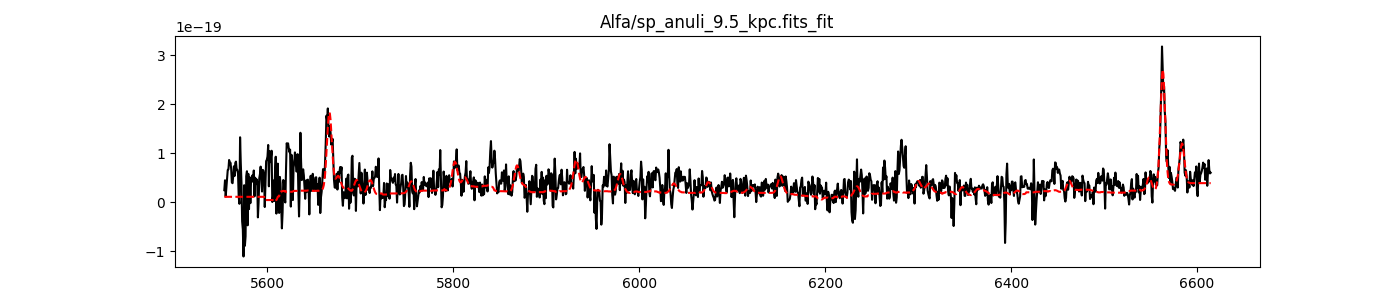

<IPython.core.display.Javascript object>


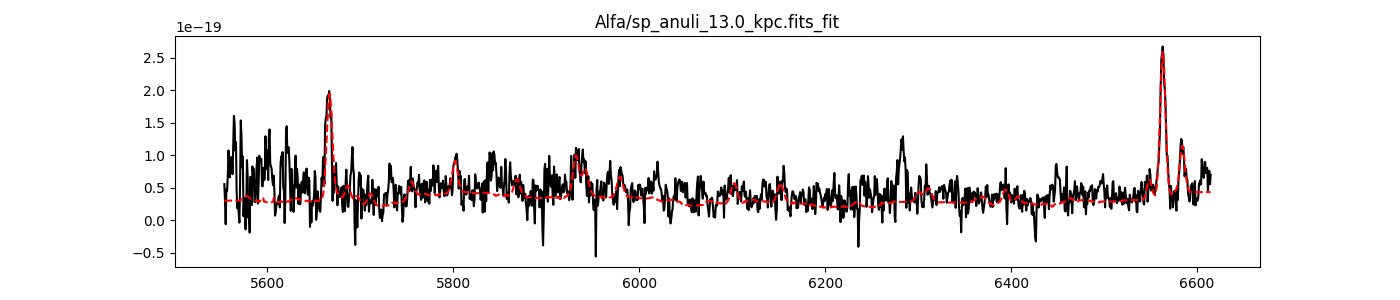

<IPython.core.display.Javascript object>


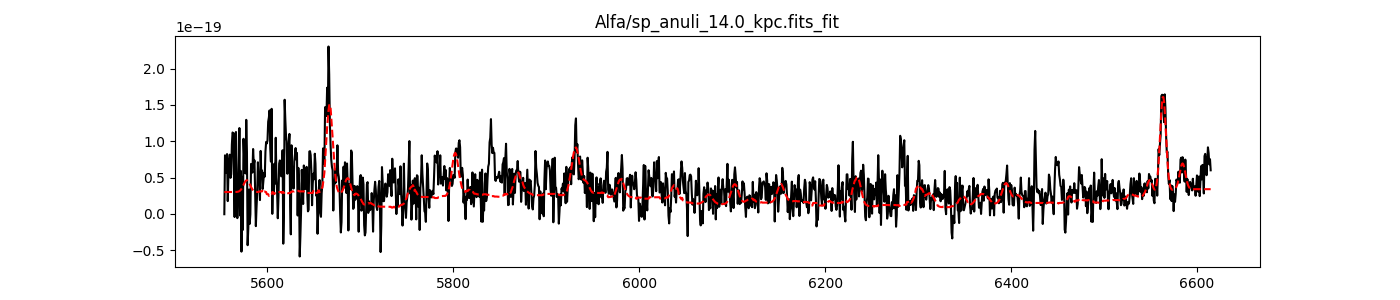

<IPython.core.display.Javascript object>


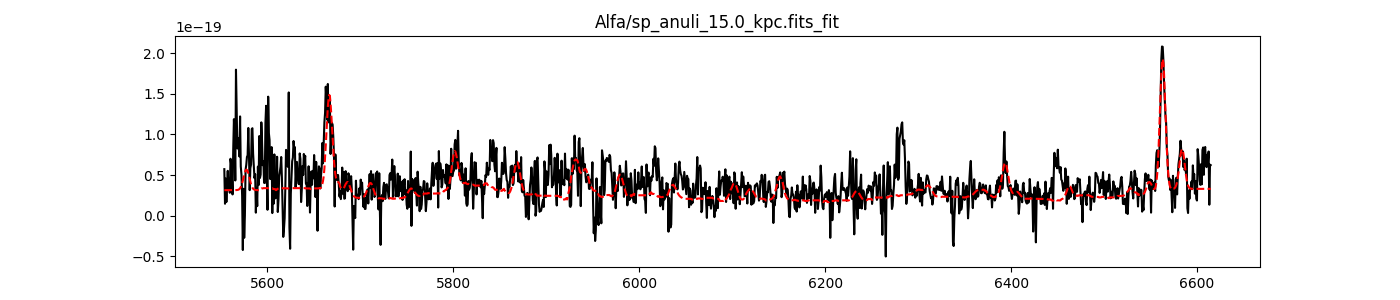

<IPython.core.display.Javascript object>


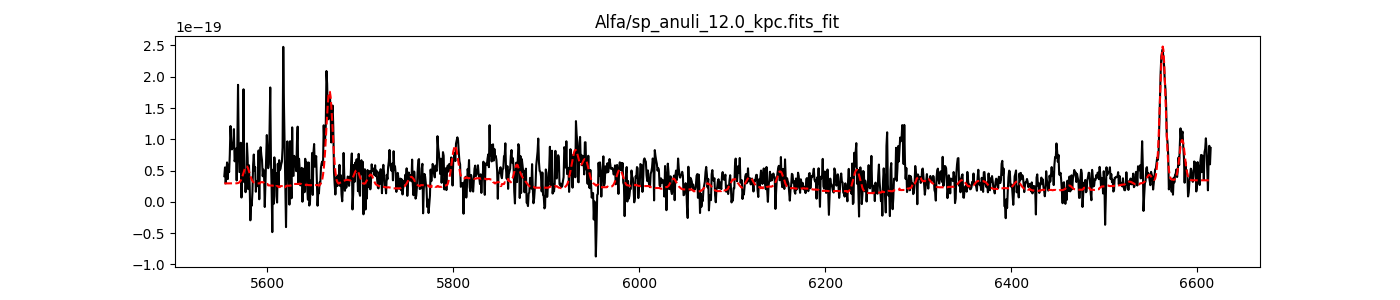

<IPython.core.display.Javascript object>


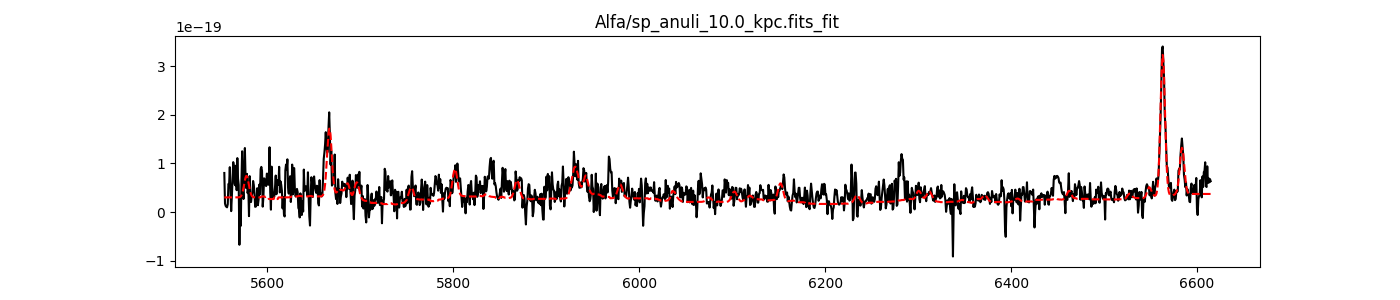

<IPython.core.display.Javascript object>


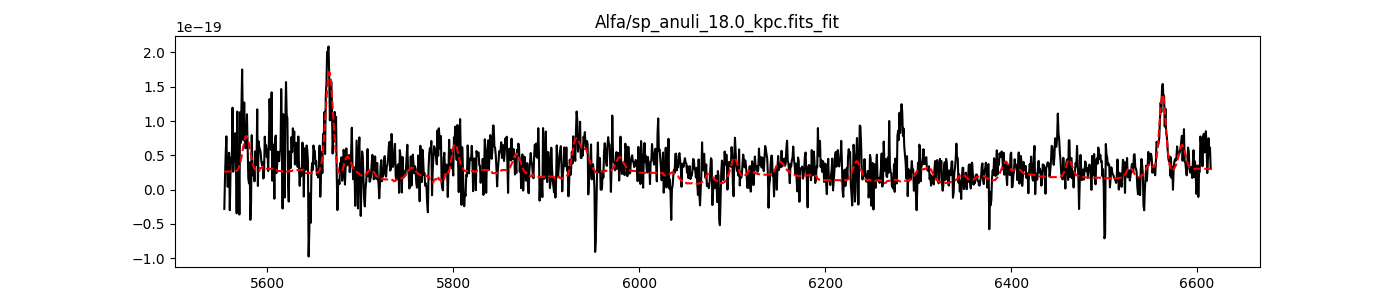

<IPython.core.display.Javascript object>


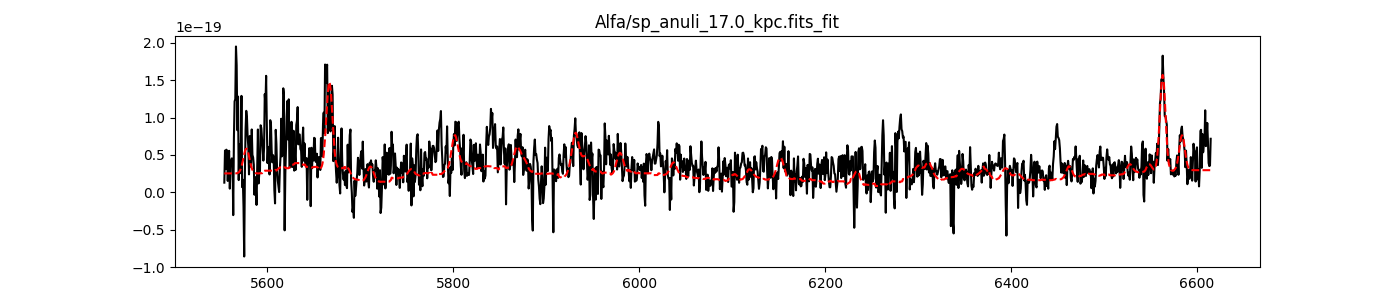

<IPython.core.display.Javascript object>


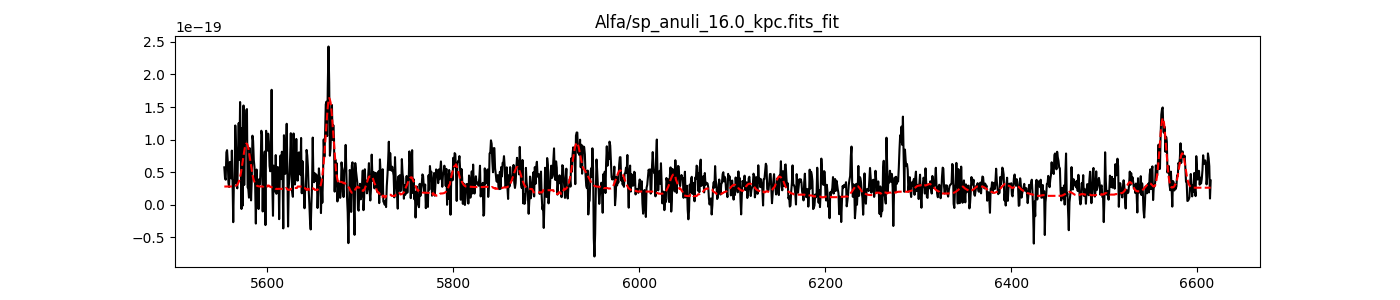

<IPython.core.display.Javascript object>


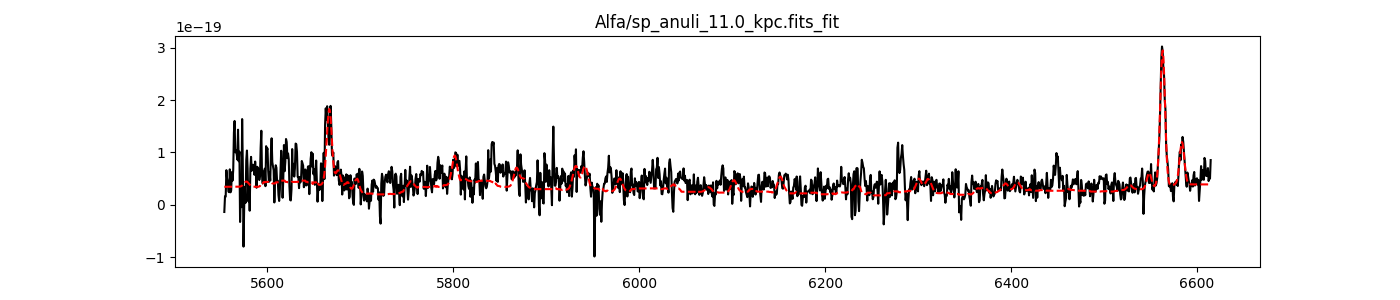

<IPython.core.display.Javascript object>


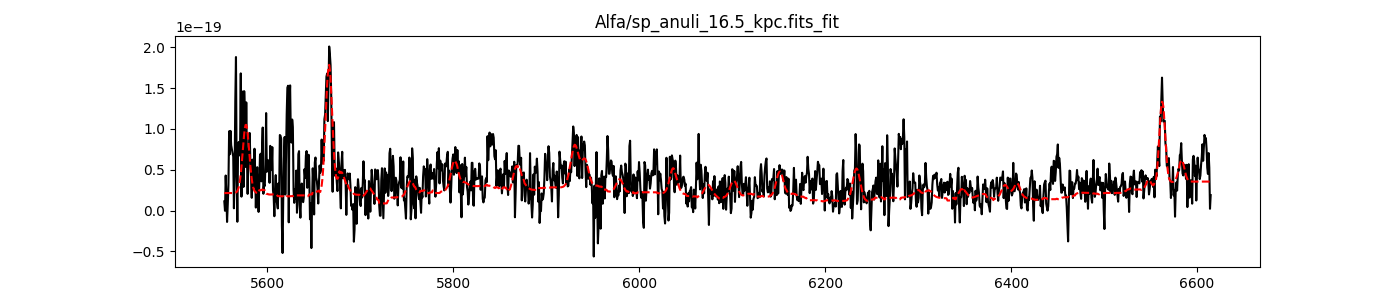

<IPython.core.display.Javascript object>


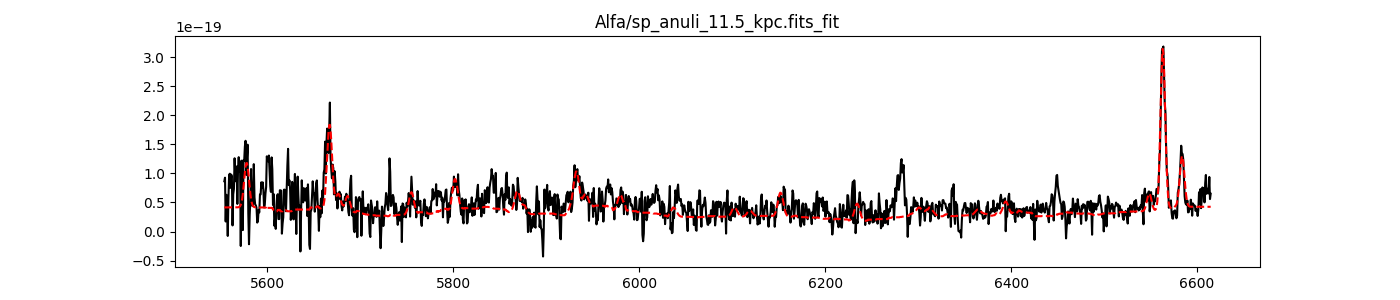

<IPython.core.display.Javascript object>


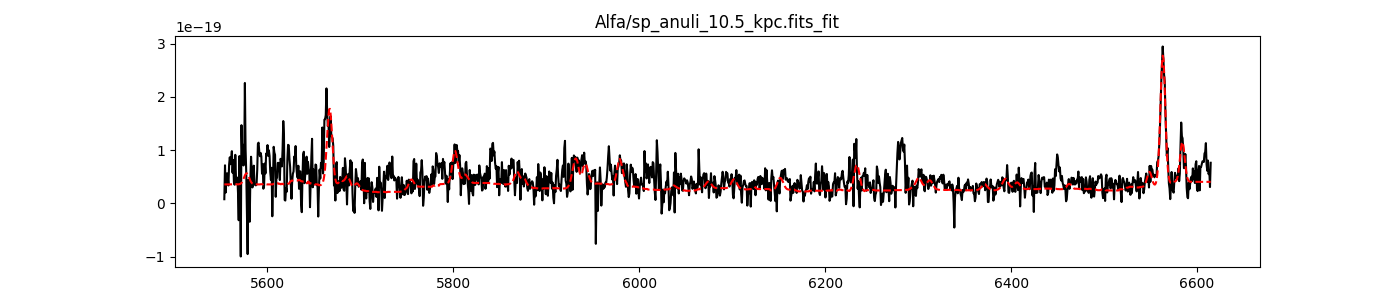

<IPython.core.display.Javascript object>


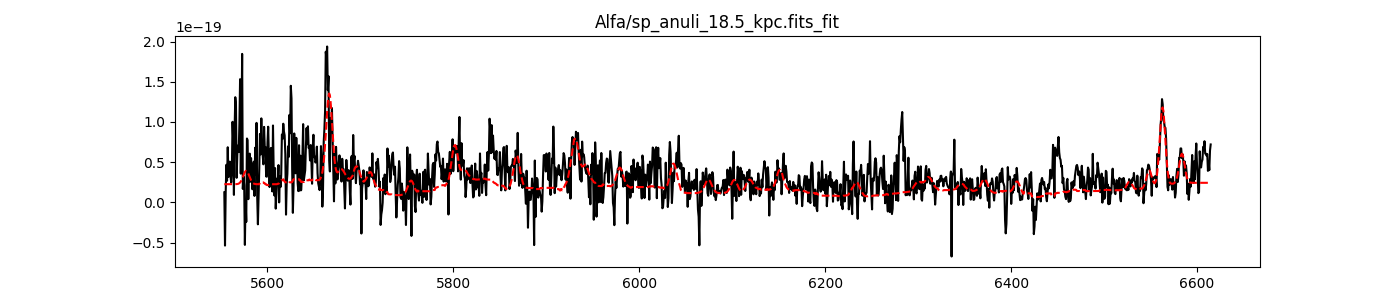

<IPython.core.display.Javascript object>


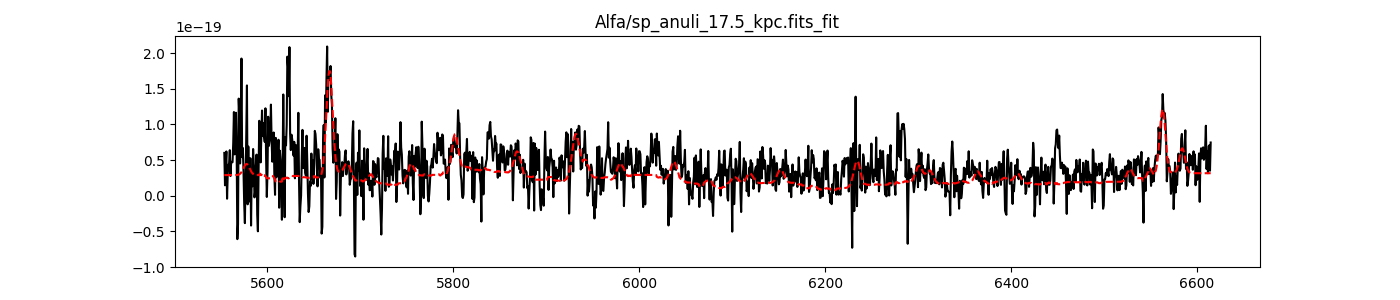

<IPython.core.display.Javascript object>


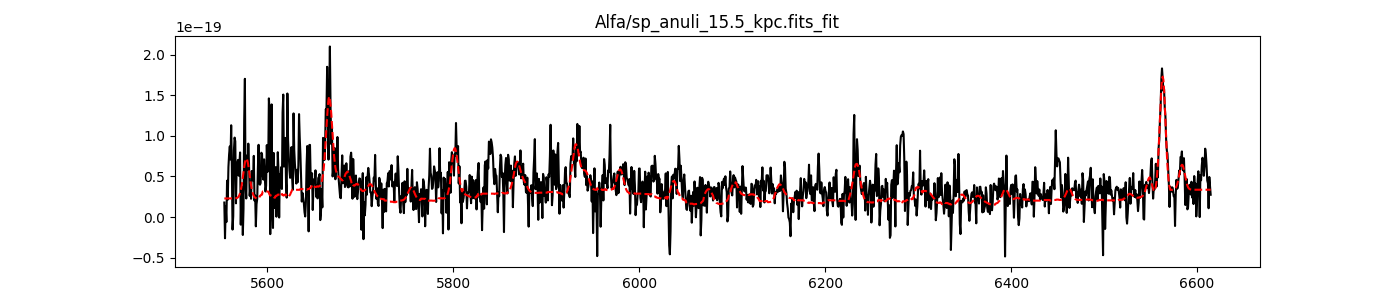

<IPython.core.display.Javascript object>


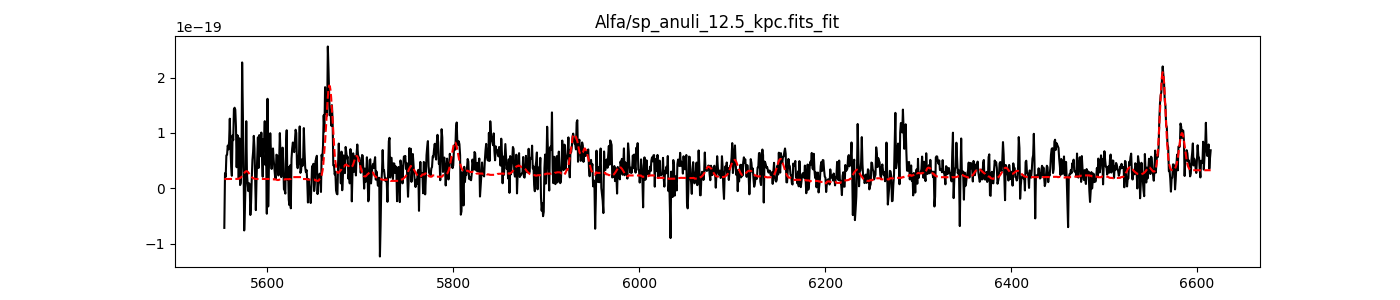

<IPython.core.display.Javascript object>


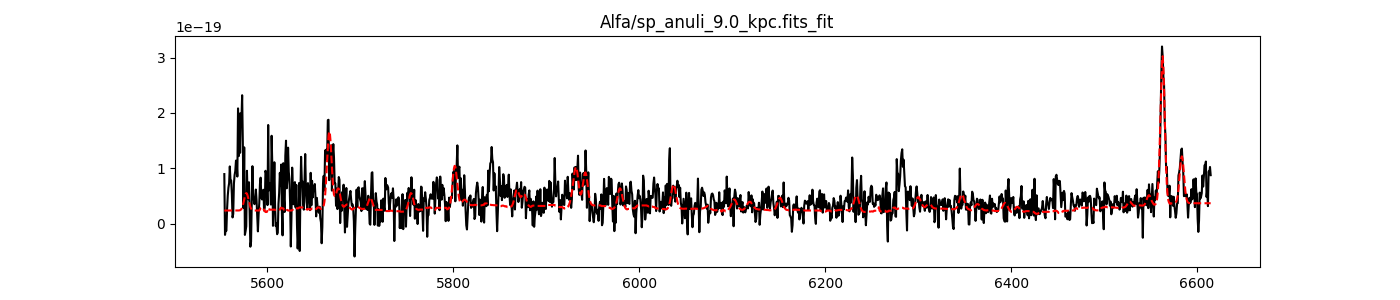

<IPython.core.display.Javascript object>


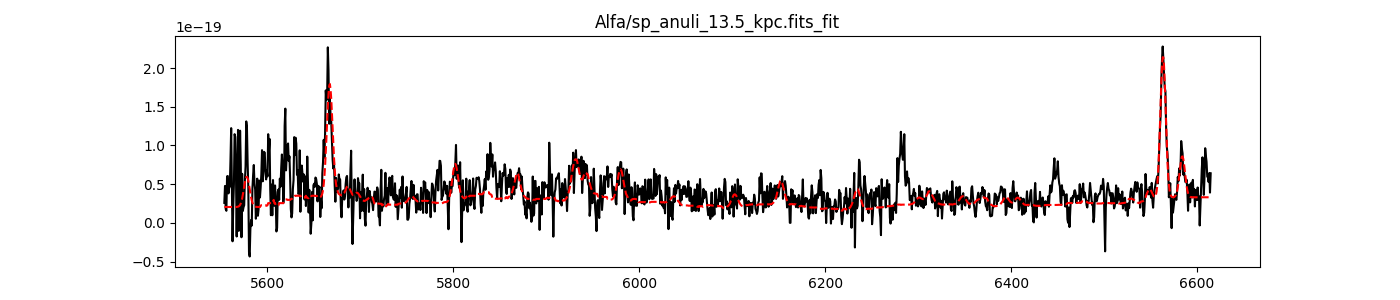

<IPython.core.display.Javascript object>


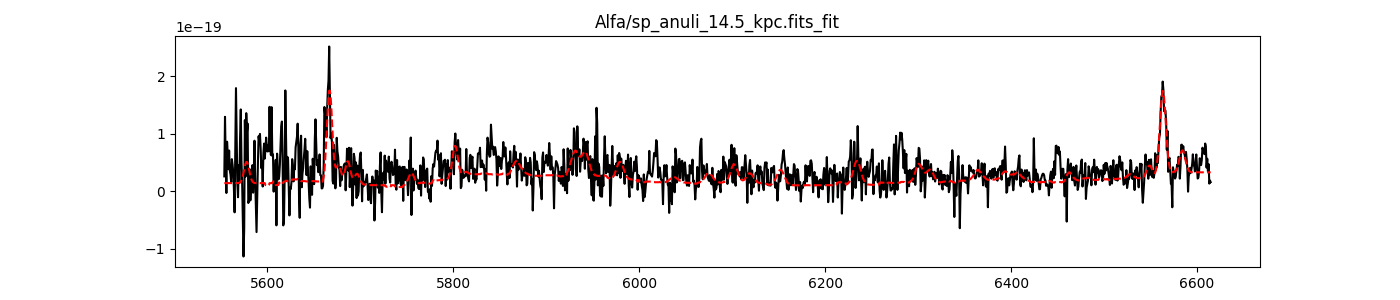

In [102]:
for spfile in glob.glob('Alfa/sp_anuli_*.fits_fit'):
    
    fig, ax = plt.subplots(1,1,figsize=(14,3))

    lbd, sp, fit = np.loadtxt(spfile,usecols=(0,1,2),unpack=True)
    h = fits.getheader(spfile.replace('Alfa/','Spectra/').replace('.fits_fit','.fits'))

    ax.plot(lbd,sp,color='k')
    ax.plot(lbd,fit,color='r',linestyle='--')

    ax.set_title(spfile)

Prepare files and fit metallicity

In [103]:
def prepare_array(filename):
    
    lbd, f, err, fwhm  = np.genfromtxt(filename,unpack=True,usecols=(1,2,3,5))
    lbd = list(lbd)

    cont = np.genfromtxt(filename.replace('lines','fit'),usecols=(1))
    cont_mean,_, cont_noise = sigma_clipped_stats(cont[1100:1275]) # empty of emission lines
    
    flx = []
    unc = []

    for l in[6562.77, 6583.5]:
        try:
            flx.append(f[lbd.index(l)])
            unc.append(err[lbd.index(l)])
        except ValueError:
            flx.append(np.nan)
            unc.append(np.nan)
    
    # Put in in the correct order:
          #'[OII]3727', '[NeIII]', 'H7', 'Hd',   'Hg',   'Hb',    '[OIII]4959','[OIII]5007','Ha','[NII]6584'
    data = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, flx[0],flx[1]] 
    err  = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, unc[0],unc[1]] 

    return data, err

In [104]:
## Prepare input files
from met_and_ext_mcmc import make_obs_file

for filename in glob.glob('Alfa/sp_anu*.fits_lines'):
    try:
        flux, uncertainties = prepare_array(filename)
        make_obs_file(flux,uncertainties,filename.replace('.fits_lines','.obs'))
    except TypeError:
        print(filename)


In [105]:
from met_and_ext_mcmc import fit_metallicity_and_extinction, calculate_SFR_from_Ha, calculate_SFR_from_OII

## Run mcmc code
met = []
ext = []
emet = []
eext = []

spectra = []
for f in glob.glob('Alfa/sp_anuli*obs'):
    spectra.append(f)
    try:
        mid_m,err_m,mid_t,err_t,samples= fit_metallicity_and_extinction(f,t_range=(0,1.0),m_range=(8.0,9.3),include=[5], # 9.2 in 12+log(O/H) is M08 limit
                                                                             extincion_law='Calzetti',nsteps=200,save=False,plot_title=None)
        
        met.append(mid_m)
        emet.append(err_m)
        ext.append(mid_t)
        eext.append(err_t)
    except ValueError:
        print('Did not fit %s'%f)
        met.append(np.nan)
        ext.append(np.nan)
        emet.append(np.nan)
        eext.append(np.nan)

MCMCing for 200 steps
 0.0%
49.7%
99.4%
Metallicity : 8.85$^{+0.15}_{-0.17}$
Extinction : 0.49$^{+0.34}_{-0.33}$
MCMCing for 200 steps
 0.0%
49.7%
99.4%
Metallicity : 8.98$^{+0.11}_{-0.08}$
Extinction : 0.48$^{+0.34}_{-0.33}$
MCMCing for 200 steps
 0.0%
49.7%
99.4%
Metallicity : 8.98$^{+0.11}_{-0.08}$
Extinction : 0.48$^{+0.34}_{-0.32}$
MCMCing for 200 steps
 0.0%
49.7%
99.4%
Metallicity : 8.98$^{+0.15}_{-0.12}$
Extinction : 0.53$^{+0.32}_{-0.34}$
MCMCing for 200 steps
 0.0%
49.7%
99.4%
Metallicity : 8.97$^{+0.17}_{-0.16}$
Extinction : 0.51$^{+0.33}_{-0.34}$
MCMCing for 200 steps
 0.0%
49.7%
99.4%
Metallicity : 8.95$^{+0.13}_{-0.11}$
Extinction : 0.51$^{+0.33}_{-0.35}$
MCMCing for 200 steps
 0.0%
49.7%
99.4%
Metallicity : 9.06$^{+0.17}_{-0.21}$
Extinction : 0.49$^{+0.35}_{-0.34}$
MCMCing for 200 steps
 0.0%
49.7%
99.4%
Metallicity : 8.94$^{+0.11}_{-0.08}$
Extinction : 0.55$^{+0.31}_{-0.36}$
MCMCing for 200 steps
 0.0%
49.7%
99.4%
Metallicity : 8.94$^{+0.09}_{-0.07}$
Extinction : 0.52$^

In [108]:
clean_file_name = [z.replace('Alfa/sp_anuli_','').replace('_kpc.obs','') for z in spectra]

t = Table(data = (clean_file_name,spectra,met,emet,ext,eext),
          names=('bin','file','met','met_unc','ext','ext_unc'))
t.sort('bin')
t.write('metallicity_SNR_anuli.dat',format='ascii.fixed_width_two_line')
t.show_in_notebook()

idx,bin,file,met,met_unc,ext,ext_unc
0,10.0,Alfa/sp_anuli_10.0_kpc.obs,8.96202061782,0.0763060813708,0.50753752134,0.340323383504
1,10.5,Alfa/sp_anuli_10.5_kpc.obs,8.97729478302,0.134297174247,0.525609644769,0.33312970384
2,11.0,Alfa/sp_anuli_11.0_kpc.obs,8.94837496935,0.0730015931492,0.490718887263,0.336848285419
3,11.5,Alfa/sp_anuli_11.5_kpc.obs,8.93747444264,0.0809752624424,0.523816329819,0.336555895134
4,12.0,Alfa/sp_anuli_12.0_kpc.obs,8.93689935746,0.0940075483161,0.548551484997,0.33655749851
5,12.5,Alfa/sp_anuli_12.5_kpc.obs,9.0434684553,0.127494673316,0.505812923297,0.339265787234
6,13.0,Alfa/sp_anuli_13.0_kpc.obs,8.98461951557,0.0945736449838,0.483783683529,0.330682381609
7,13.5,Alfa/sp_anuli_13.5_kpc.obs,8.89089092737,0.0722404865576,0.47176533327,0.337123677989
8,14.0,Alfa/sp_anuli_14.0_kpc.obs,8.90886218454,0.113708489055,0.478352011566,0.344676558173
9,14.5,Alfa/sp_anuli_14.5_kpc.obs,8.88980465337,0.0991920941513,0.45146310609,0.347270787588
